## Settings

In [1]:
import io
from typing import Any, Dict, List, OrderedDict, Union
import os
from os.path import join as osj
import cv2
import decord
import matplotlib
import matplotlib.pyplot as plt
import moviepy.editor as mpy
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib.collections import LineCollection
import random
import pandas as pd
from workoutdetector.datasets import FrameDataset, build_test_transform, RepcountHelper
from workoutdetector.utils import plot_all, plt_params, plot_per_action
from matplotlib import font_manager
import json

matplotlib.RcParams.update(plt_params())
font_path = '/mnt/c/Users/Me/AppData/Local/Microsoft/Windows/Fonts/Cairo-VariableFont_wght.ttf'
font_manager.fontManager.addfont(font_path)
font_manager.findSystemFonts(fontext='otf')
fe = font_manager.FontEntry(fname=font_path, name='Cairo')
font_manager.fontManager.ttflist.insert(0, fe) 
matplotlib.rcParams.update(plt_params())
matplotlib.rcParams['font.family'] = 'Cairo'

In [2]:
data_root = os.path.expanduser("~/data/RepCount")
anno_path = osj(data_root, "annotation.csv")
helper = RepcountHelper(data_root, anno_path)
CLASSES = helper.classes
print(CLASSES)
data = list(helper.get_rep_data(['train', 'val', 'test'], ['all']).values())
item = random.choice(data)
print(item)

['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']
video: stu3_27.mp4
class: jump_jack
count: 70
reps: [0, 27, 27, 53, 53, 78, 78, 104, 104, 131, 131, 157, 157, 181, 181, 208, 208, 235, 235, 261, 261, 285, 285, 312, 312, 337, 337, 362, 362, 390, 390, 415, 415, 439, 439, 465, 465, 490, 490, 518, 518, 544, 544, 569, 569, 593, 593, 620, 620, 645, 645, 668, 668, 694, 694, 719, 719, 746, 746, 772, 772, 799, 799, 822, 823, 847, 847, 873, 873, 900, 900, 925, 925, 950, 950, 977, 977, 1002, 1002, 1027, 1027, 1051, 1051, 1076, 1076, 1103, 1103, 1129, 1129, 1154, 1154, 1178, 1178, 1204, 1204, 1231, 1231, 1255, 1255, 1280, 1280, 1306, 1306, 1332, 1332, 1360, 1360, 1384, 1384, 1410, 1411, 1437, 1437, 1463, 1463, 1488, 1488, 1513, 1513, 1541, 1541, 1566, 1566, 1591, 1591, 1616, 1616, 1644, 1644, 1670, 1670, 1695, 1695, 1719, 1719, 1747, 1747, 1772, 1772, 1793]
fps: 29.97002997002997


In [3]:
json_dir = os.path.expanduser('~/projects/WorkoutDetector/out/acc_0.841_epoch_26_20220711-191616_1x1')
json_files = os.listdir(json_dir)
template  = '{}.stride_1_step_1.json'
print(len(json_files))
print(json_files[0])
print(json.load(open(osj(json_dir, json_files[0]))).keys())

762
stu7_51.mp4.stride_1_step_1.json
dict_keys(['video_name', 'model', 'stride', 'step', 'length', 'fps', 'input_shape', 'checkpoint', 'total_frames', 'ground_truth', 'action', 'scores'])


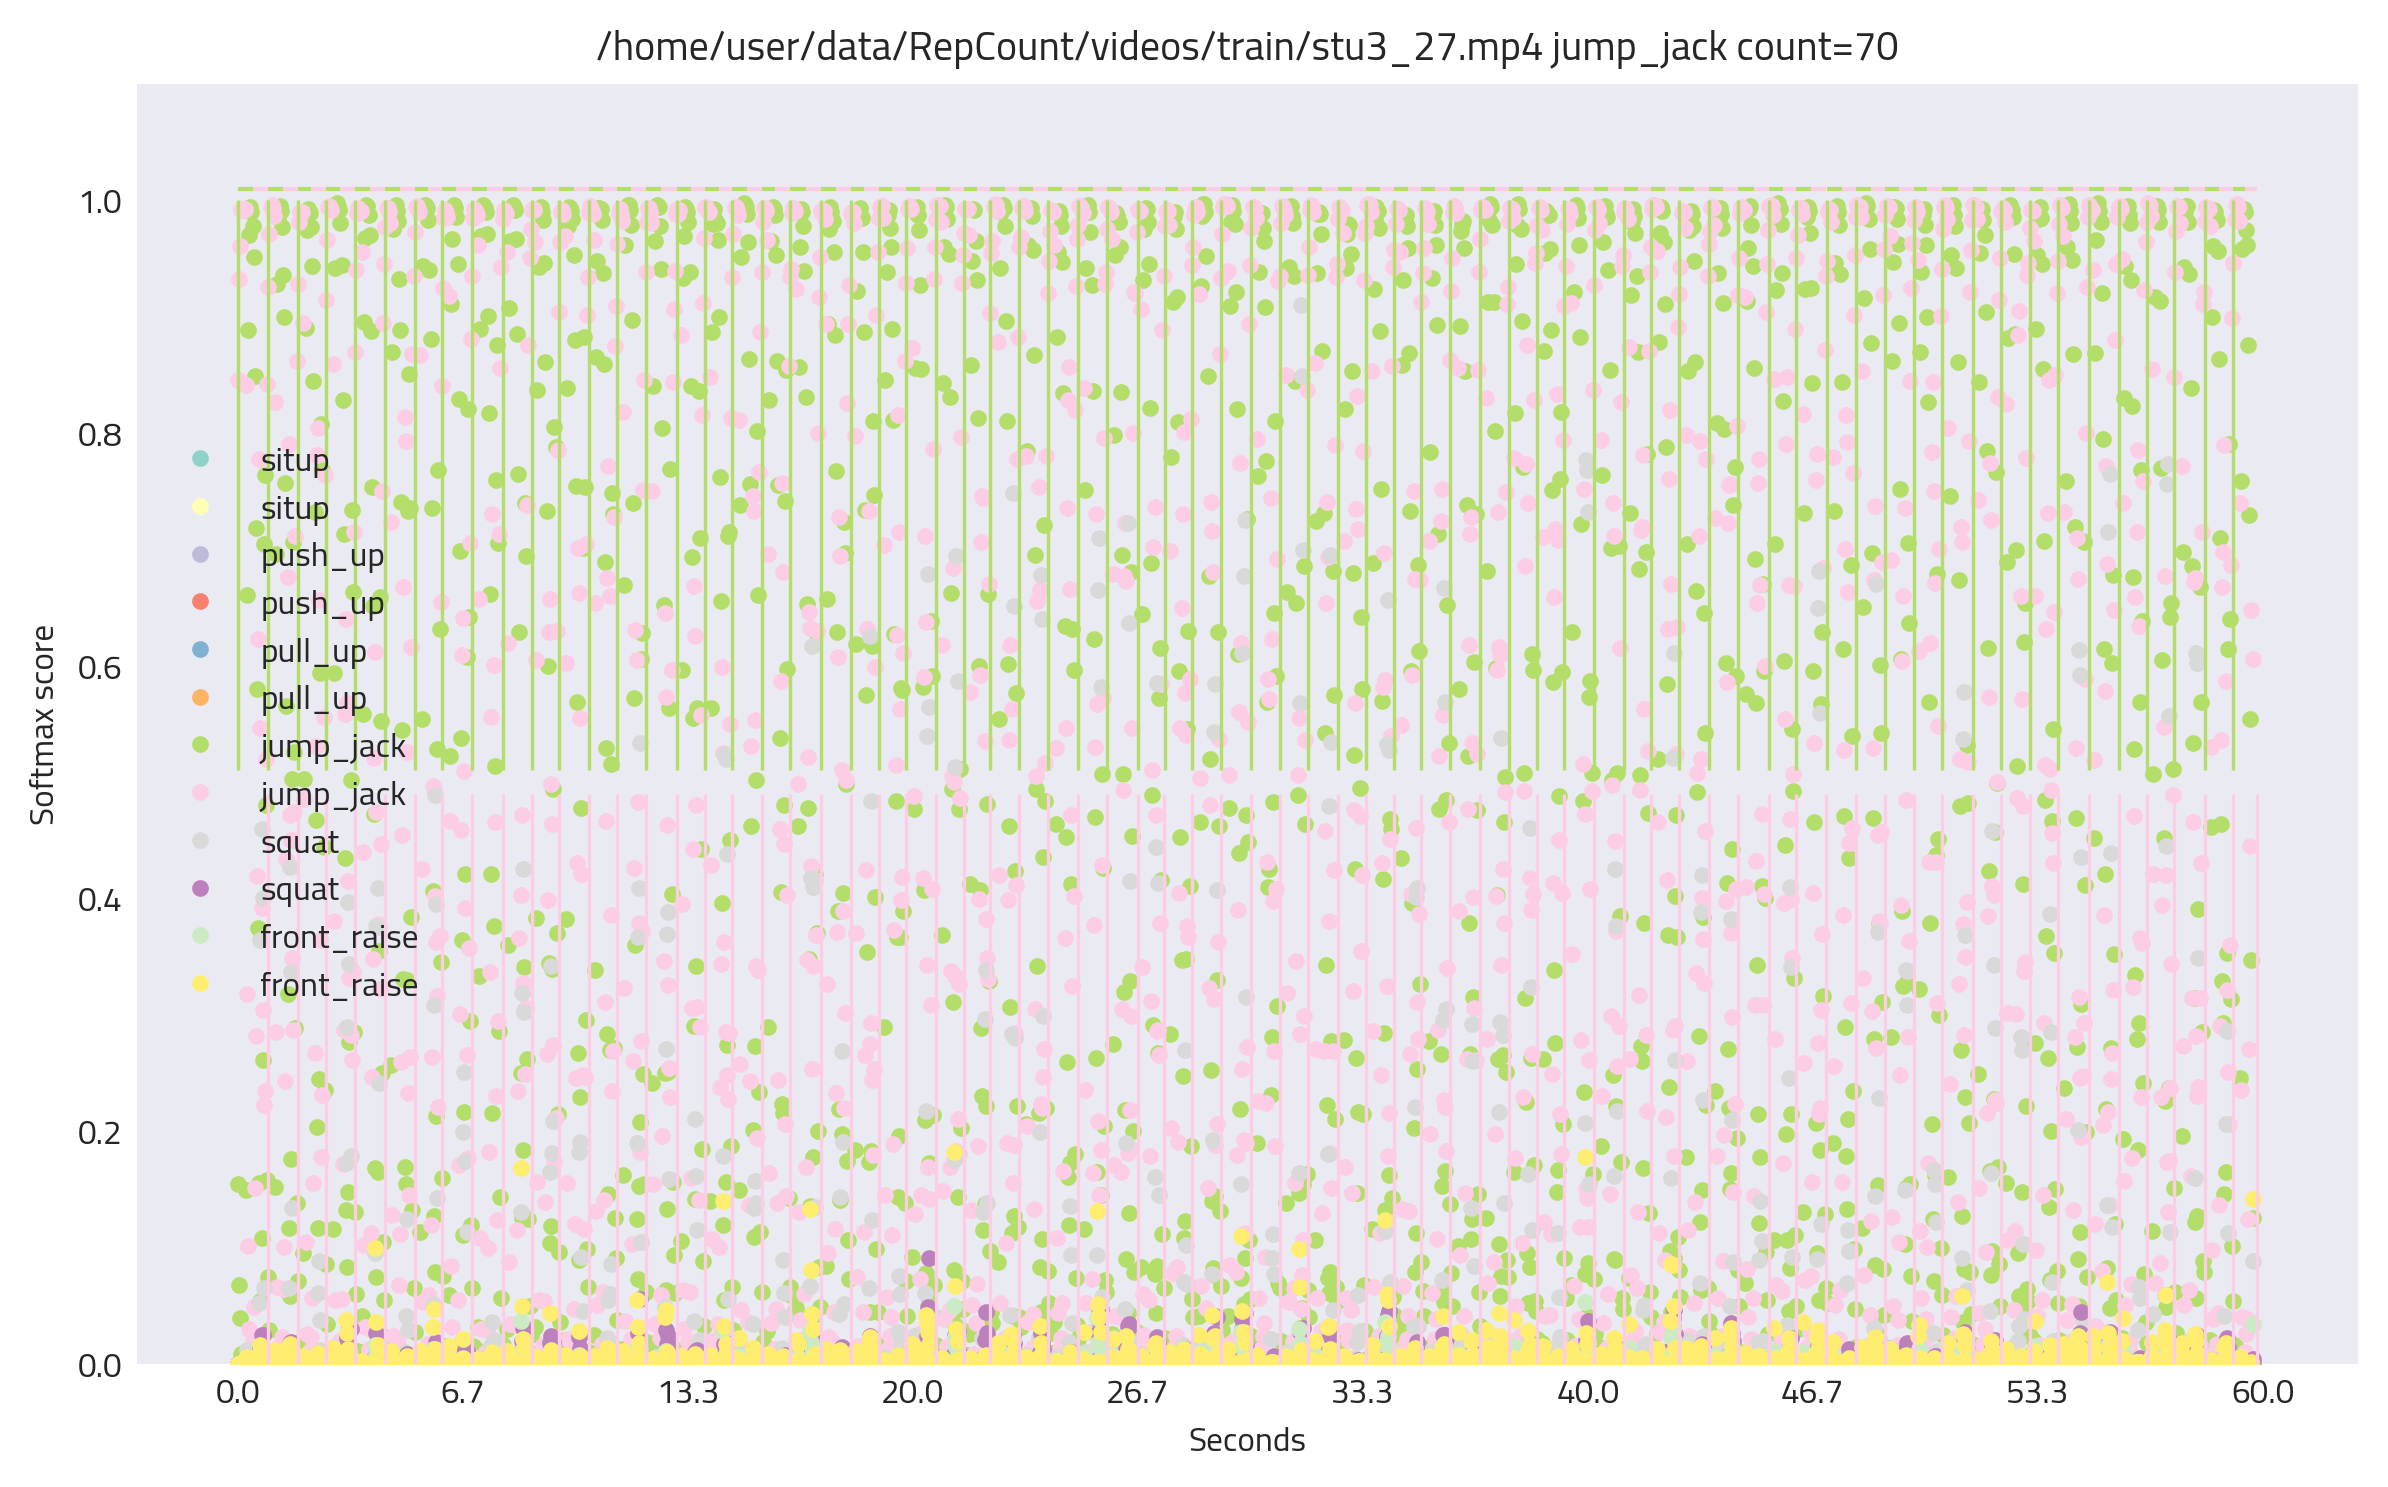

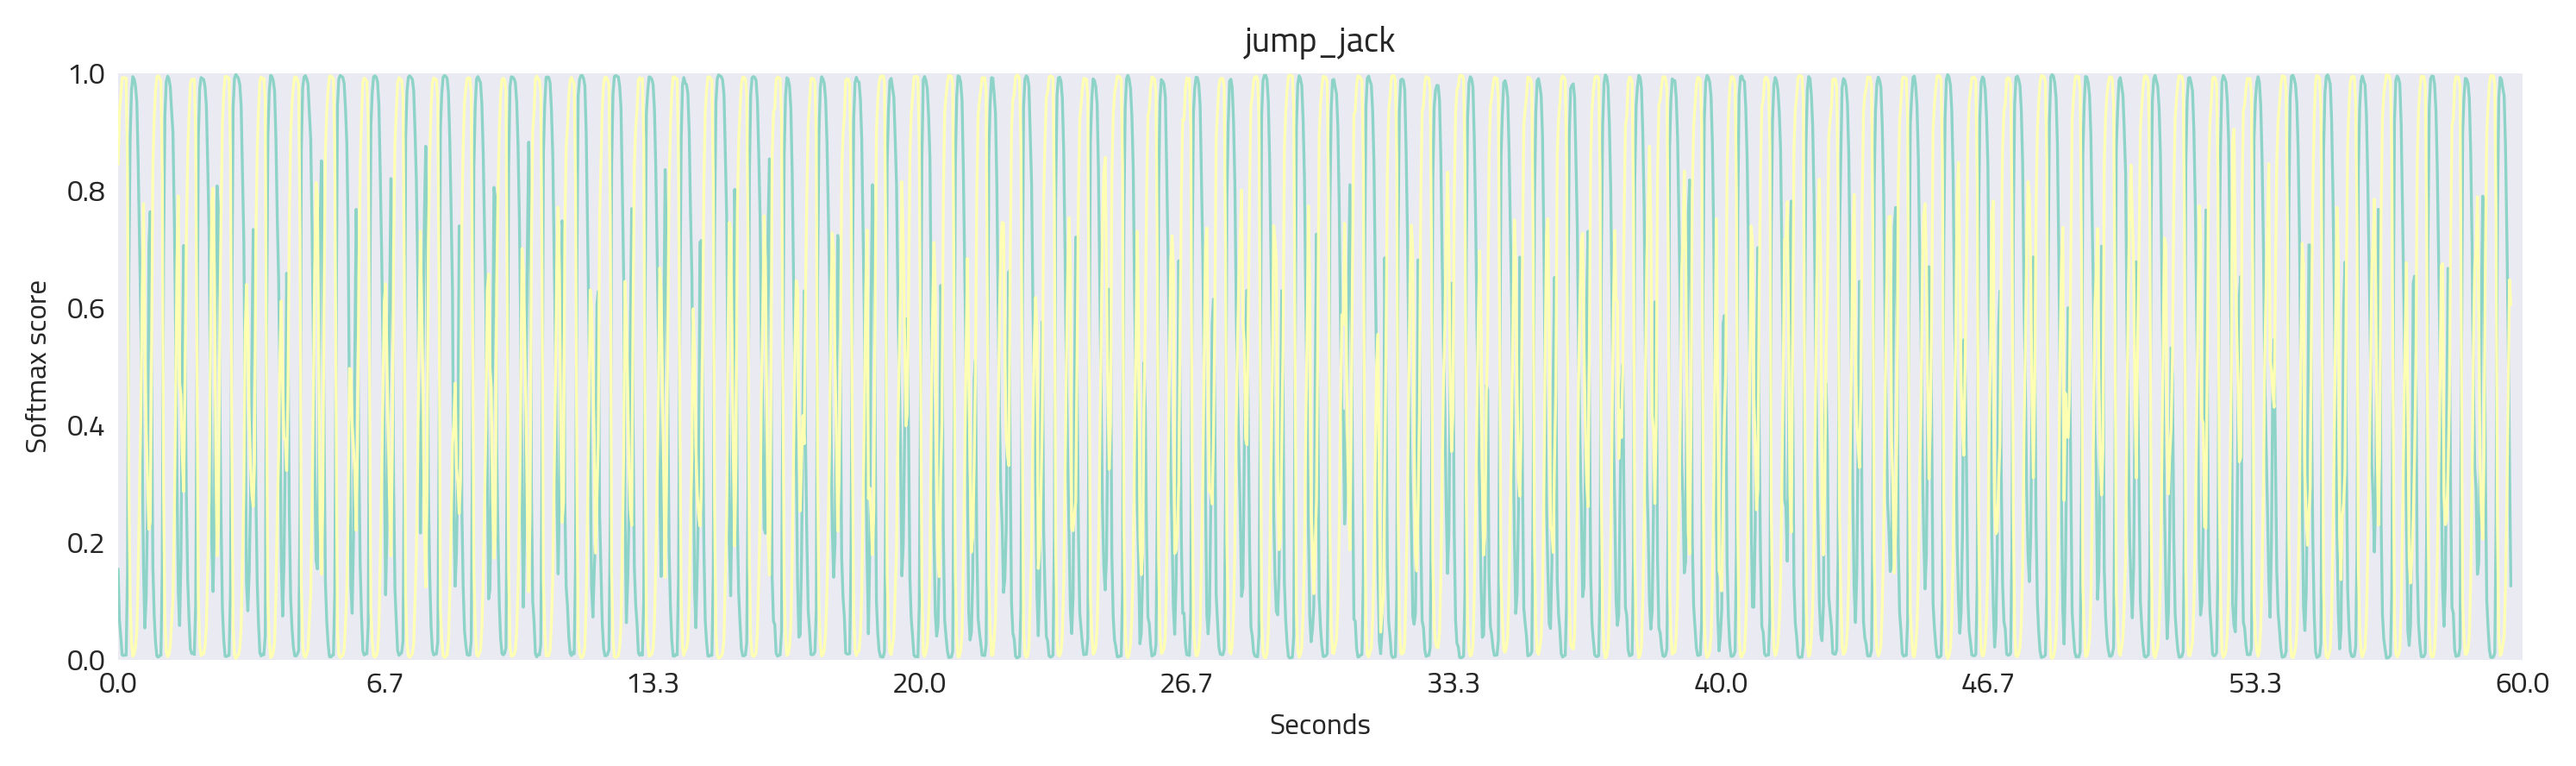

In [4]:
js = json.load(open(osj(json_dir, template.format(item.video_name))))

plot_all(js['ground_truth'], js, softmax=True, stride=1)
plot_per_action(js, softmax=True, action_only=True)

## Hidden Markov Model

- Input: a sequence of probabilities of shape (seq_len, 12)
- Output: a integer state

In [64]:
from hmmlearn import hmm
from workoutdetector.datasets import FeatureDataset
from workoutdetector.utils import pred_to_count
from torch.utils.data import DataLoader

In [183]:
def train(action):
    feat_ds = FeatureDataset(json_dir, anno_path, 'train', action, window=1, stride=1)
    # print(feat_ds.x.shape)
    # softmax_x = F.softmax(torch.from_numpy(feat_ds.x), dim=1).numpy()
    transmat, pi, means, cov = feat_ds.hmm_stats(feat_ds.x, feat_ds.y)
    # print(transmat, pi, means, cov)
    model = hmm.GaussianHMM(n_components=3, n_iter=300, covariance_type='diag')
    model.transmat_ = transmat
    model.startprob_ = pi.T
    model.means_ = means
    model.covars_ = cov
    softmax_x = F.softmax(torch.from_numpy(feat_ds.x.squeeze(1)), dim=1)
    # model.fit(softmax_x.numpy())
    return model

def reps_to_label(reps, total):
    y = [0] * total
    for start, end in zip(reps[::2], reps[1::2]):
        mid = (start + end) // 2
        y[start:mid] = [1] * (mid - start)
        y[mid:end] = [2] * (end - mid)  # plus 1 because no-class is 0
    return y

def hmm_infer(model, x, gt_reps):
    gt_labels = reps_to_label(gt_reps, len(x))
    y = model.predict(x)
    acc = (y == gt_labels[:len(y)]).sum() / len(gt_labels)
    gt_count = len(gt_reps) // 2
    count, reps = pred_to_count(y-1, stride=1, step=1) # minus 1 because no-class is 0
    diff = abs(count - gt_count)
    obo = 1 if (diff <= 1) else 0
    err = diff / gt_count if gt_count > 0 else diff
    return obo, err, acc,  reps

action = 'situp'
model = train(action)

### Predict

(1519, 12) 1527
count 16 name stu8_53.mp4 situp
pred count 22
obo=0 err=0.375 acc=0.40947992100065833


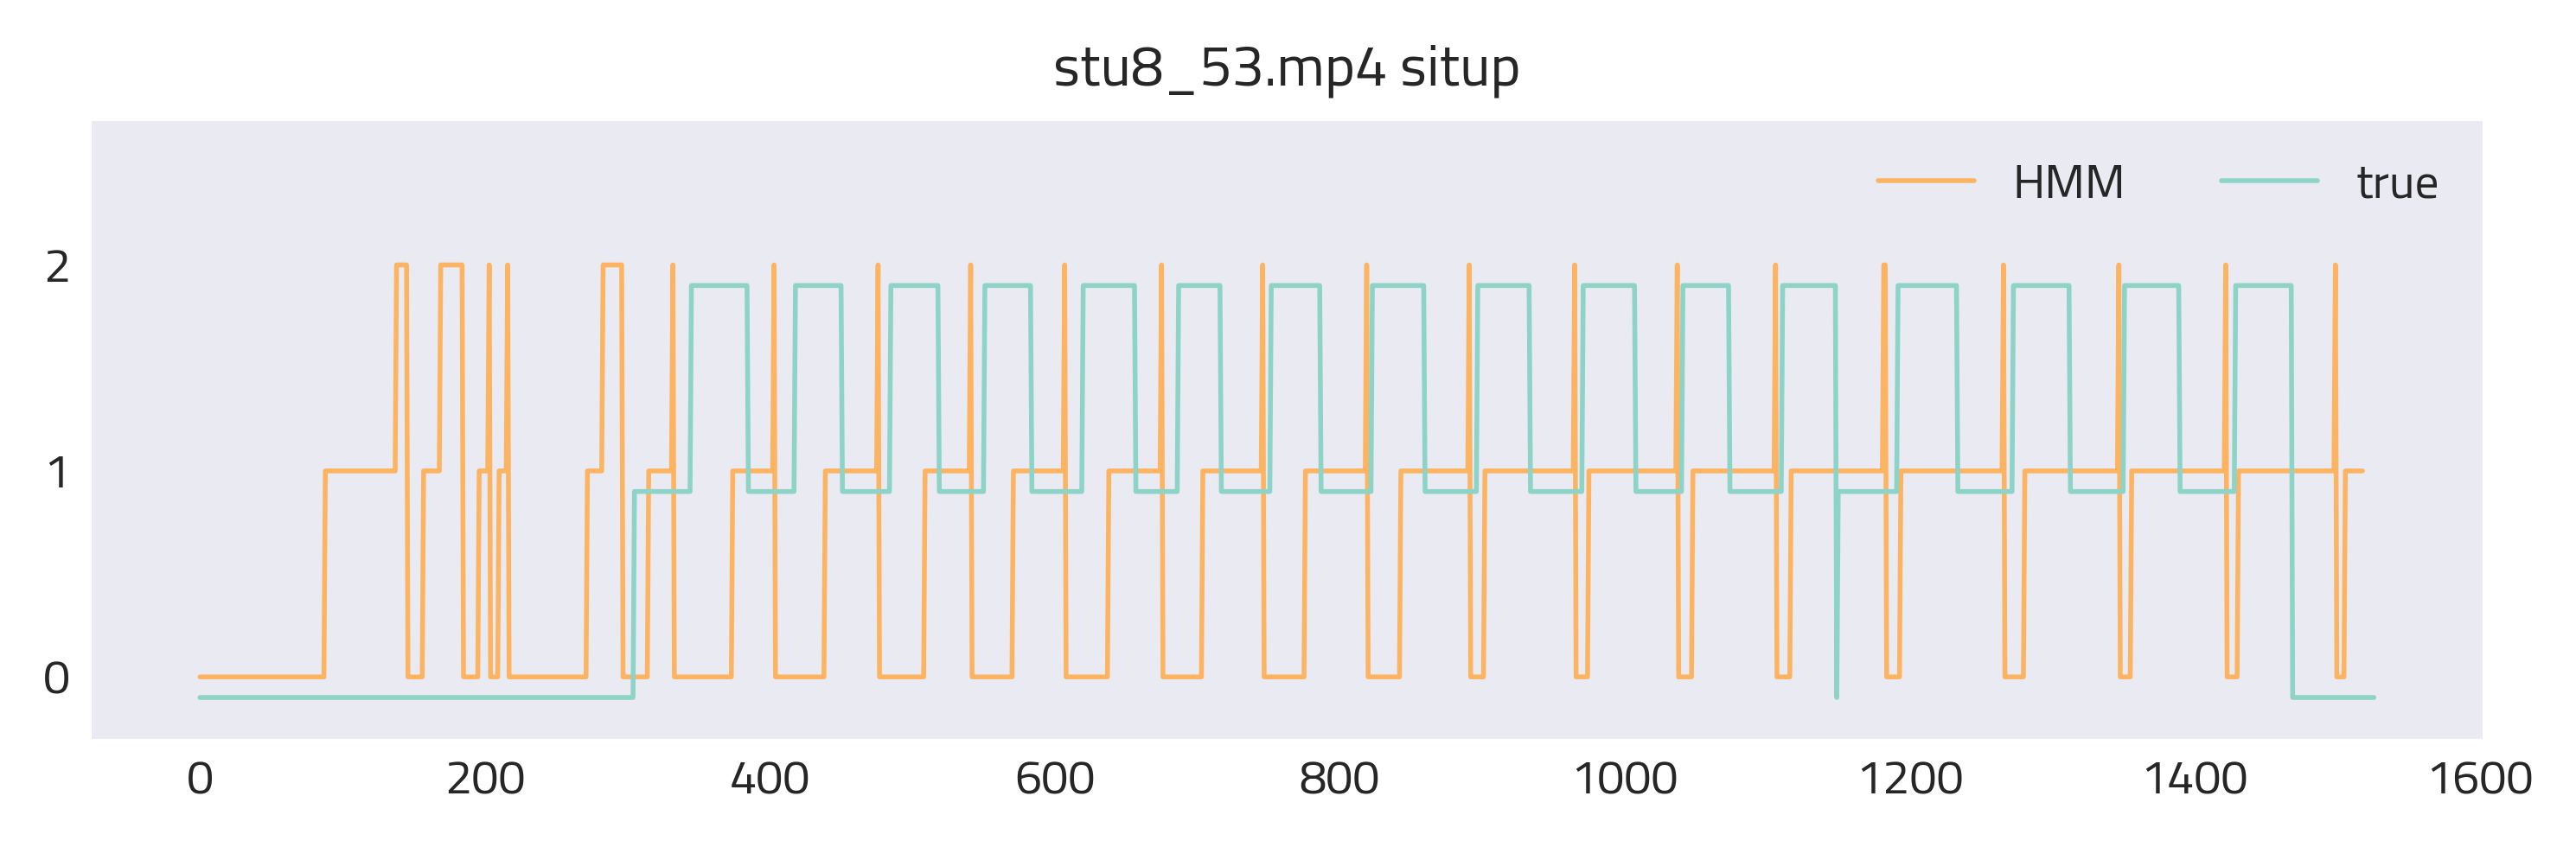

In [190]:
val_data = list(helper.get_rep_data(['val'], [action]).values())
item = random.choice(val_data)

val_x = []
js = json.load(open(osj(json_dir, template.format(item.video_name))))
for i,v in js['scores'].items():
    val_x.append(np.array(list(v.values())))
val_x = np.array(val_x)
val_y = np.array(reps_to_label(item.reps, item.total_frames))
print(val_x.shape, len(val_y))

pred = model.predict(val_x)
print('count', len(js['ground_truth'])//2, 'name', item.video_name, item.class_)

obo, err, acc, reps = hmm_infer(model, val_x, item.reps)
print('pred count', len(reps) // 2)
print(f'obo={obo} err={err} acc={acc}')
fig= plt.figure(figsize=(6,2), dpi=500)
plt.tight_layout()
plt.plot(pred, 'C5', label='HMM')
plt.plot(val_y-0.1, 'C0', label='true')
# plt.plot(reps_to_label(reps, item.total_frames), 'C1', label='reps')
plt.yticks(range(3))
plt.ylim(-0.3, 2.7)
plt.legend(ncol=2)
plt.title(f'{item.video_name} {item.class_}')
plt.show()

### Eval

In [100]:
def eval_subset(model, split, action):
    test_data = list(helper.get_rep_data([split], [action]).values())
    total_obo, total_err, total_acc = 0, 0, 0
    for item in test_data:
        test_x = []
        js = json.load(open(osj(json_dir, template.format(item.video_name))))
        for i,v in js['scores'].items():
            test_x.append(np.array(list(v.values())))
        test_x = np.array(test_x)
        test_y = reps_to_label(item.reps, item.total_frames)
        test_y = np.array(test_y)
        test_y[test_y != 0] -= CLASSES.index(item.class_) * 2 # map class id to 0, 1, 2

        pred = model.predict(test_x)
        obo, err, acc, reps = hmm_infer(model, val_x, item.reps)
        total_obo += obo
        total_err += err
        total_acc += acc

    obo_rate = total_obo / len(test_data)
    err_rate = total_err / len(test_data)
    acc_rate = total_acc / len(test_data)
    return dict(split=split, action=action, obo=obo_rate, mae=err_rate, hmm_acc=acc_rate)

result = []
for action in CLASSES:
    model = train(action)
    for split in ['train', 'val', 'test']:
        result.append(eval_subset(model, split, action))

df = pd.DataFrame(result)
df.to_csv('hmm_result.csv')
print(df.to_latex(index=False))

\begin{tabular}{lllrrr}
\toprule
{} &  split &       action &       obo &        mae &   hmm\_acc \\
\midrule
0  &  train &        situp &  0.031915 &   1.000000 &  0.627069 \\
1  &    val &        situp &  0.055556 &   1.000000 &  0.571925 \\
2  &   test &        situp &  0.050000 &   1.000000 &  0.573876 \\
3  &  train &      push\_up &  0.080460 &   1.533643 &  0.550777 \\
4  &    val &      push\_up &  0.111111 &   1.151386 &  0.600524 \\
5  &   test &      push\_up &  0.000000 &   1.608882 &  0.508321 \\
6  &  train &      pull\_up &  0.031915 &   3.590176 &  0.275135 \\
7  &    val &      pull\_up &  0.000000 &   5.209023 &  0.303173 \\
8  &   test &      pull\_up &  0.052632 &   3.812696 &  0.275376 \\
9  &  train &    jump\_jack &  0.013158 &   3.208728 &  0.405631 \\
10 &    val &    jump\_jack &  0.000000 &   3.534580 &  0.379096 \\
11 &   test &    jump\_jack &  0.038462 &   3.021169 &  0.405284 \\
12 &  train &        squat &  0.000000 &   9.317024 &  0.282075 \\
13 &    va

## MLP

In [30]:
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, x):
        return self.layers(x)

window = 10
model_mlp = MLP(12*window, 100, 13)

In [63]:
train_x, train_y = [], []
for item in data:
    x, y = [], []
    js = json.load(open(osj(json_dir, template.format(item.video_name))))
    for i,v in js['scores'].items():
        x.append(np.array(list(v.values())))
    y = reps_to_label(item.reps, item.total_frames, item.class_)
    x, y = torch.Tensor(x), torch.Tensor(y)
    n = len(x) - window + 1
    for i in range(n):
        train_x.append(x[i:i+window])
        train_y.append(y[7+i])

print(len(train_x), len(train_y))
print(train_x[0].shape, train_y[0])

loader = zip(train_x, train_y)
model_mlp.to('cuda')
train_x = torch.stack(train_x).to('cuda')
train_y = torch.stack(train_y).to('cuda')

class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return len(self.x)
    
train_loader = DataLoader(Dataset(train_x, train_y), batch_size=64, shuffle=True)
val_loader = DataLoader(Dataset(val_x, val_y), batch_size=64, shuffle=False)
next(iter(loader))[0].shape

640141 640141
torch.Size([10, 12]) tensor(11.)


torch.Size([64, 10, 12])

In [64]:
def train(model, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for _ in range(10):
        model.train()
        model.zero_grad()
        train_loss = 0
        for x, y in train_loader:
            output = model(x)
            loss = F.cross_entropy(output, y.long())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(loader)
        print('train loss', train_loss)

        model.eval()
        val_loss = 0
        val_acc = 0
        for x, y in val_loader:
            output = model(x)
            loss = F.cross_entropy(output, y.long())
            val_loss += loss.item()
            val_acc += (output.argmax(dim=1) == y).sum().item()
        val_loss /= len(loader)
        val_acc /= len(train_x)
        print('val loss', val_loss)
        print('val acc', val_acc)

## LSTM

In [67]:
from torch.autograd import Variable

class LSTM(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda())
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda())
        x, (h, c) = self.rnn(x, (h0, c0))
        o = self.layers(h[-1])
        return o

model_lstm = LSTM(12, 2, 128, 13).cuda()
model_lstm(torch.randn(64, 10, 12).cuda()).shape

torch.Size([64, 13])

In [ ]:
train(model_lstm, train_loader, val_loader)